<a href="https://colab.research.google.com/github/jnieus01/Dinov2-review/blob/main/presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

DINOv2 was released by Meta AI in spring of 2023, and builds on self-supervised learning approaches to learn visual features when given a large, curated dataset.

### What is interesting about DINOv2?

- It provides high-performance features that can be directly used for simple linear classification without fine-tuning (i.e., out-of-the-box)

- Found better results from DINOv2's features on monocular depth estimation (identifying objects in the foreground of an image versus the background) than state-of-the-art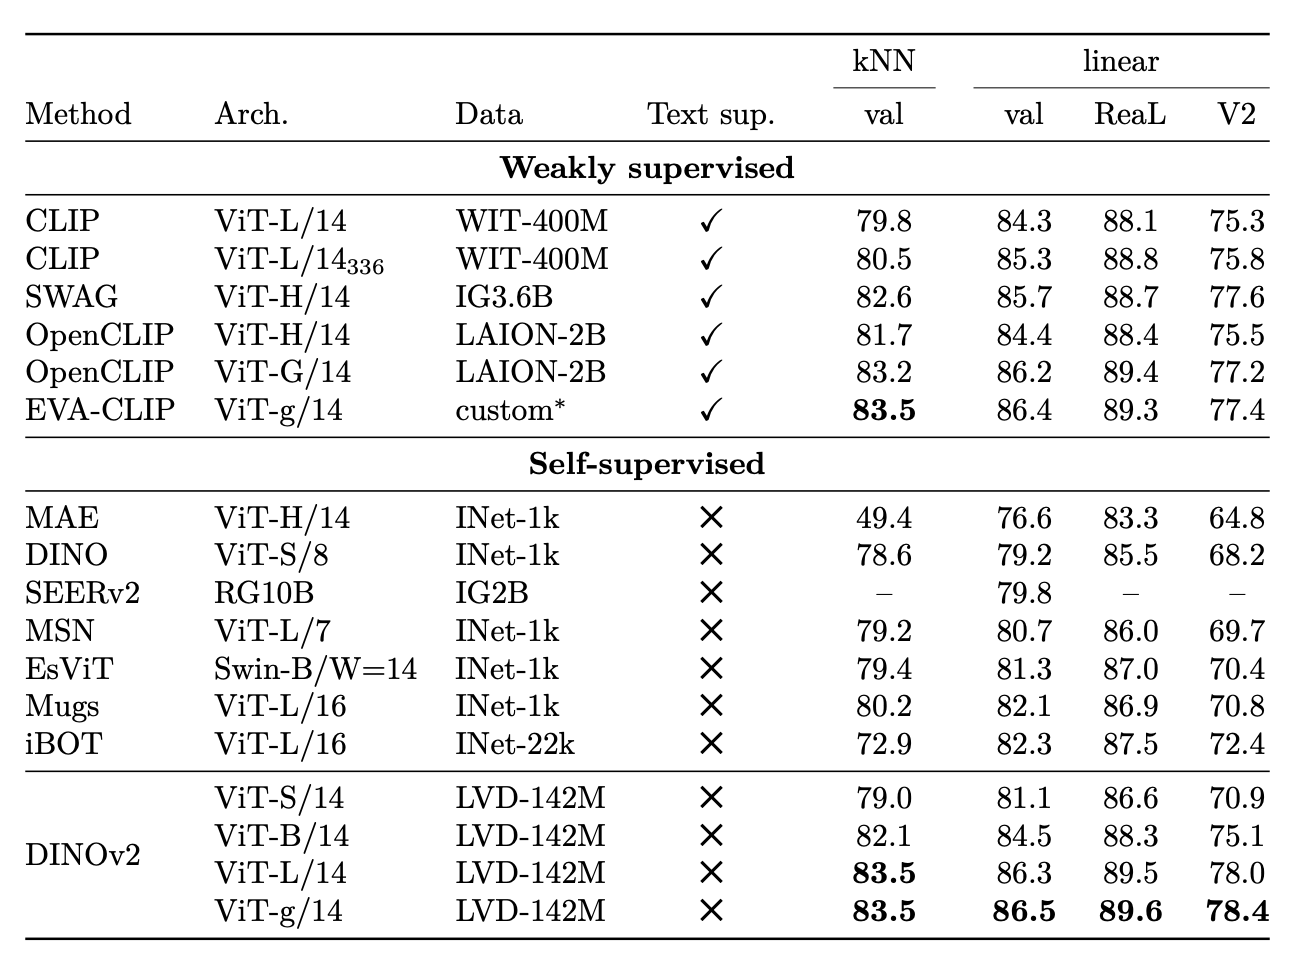


## Background

Image-text pretraining has been a common approach used to train computer vision models. The problem with this approach is that it has notable limitations in terms of the richness and granularity of features that can be captured by the trained model and it is bottlenecked by its need for human-annotated data.

> **Image-text pretraining**   
Training dataset comprises images with captions as labels. Uses a visual encoder to process images and a text encoder to process text inputs so that the model learns to encode both images and text into a shared representational space.

The research in the DINOv2 addresses these issues by implementing a pipeline to automate the curation of its training dataset and bringing algorithmic and technical improvements to a self-supervised learning approach introduced by earlier research, including iBOT.


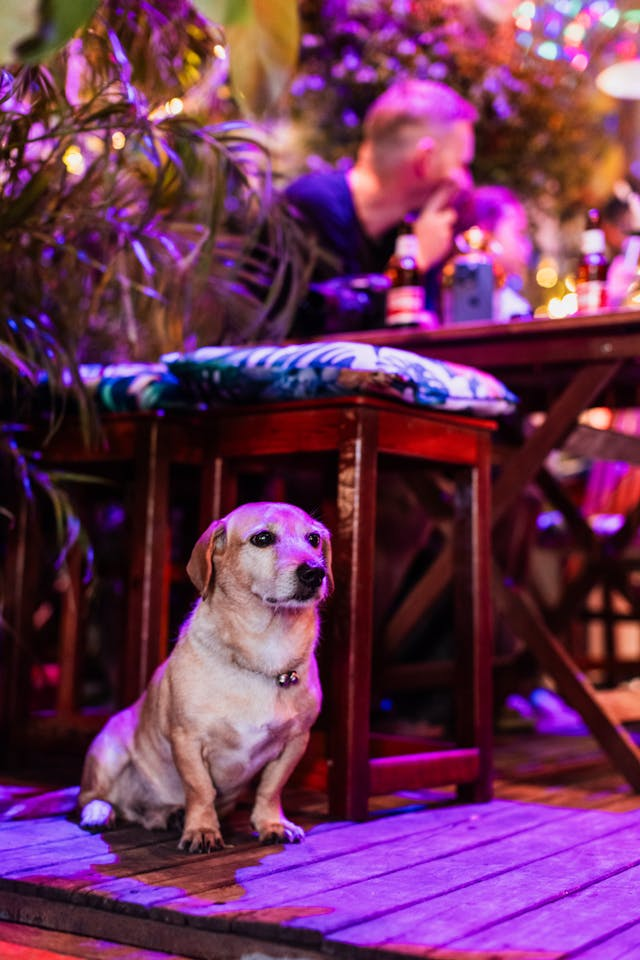

## DINOv2's approach

1. Pipeline to automate the curation of a large image dataset

2. Algorithmic and technical improvements to self-supervised learning approaches used in DINO and iBOT

3. DINOv2's training algorithm is based on self-distillation, which makes it easier to create smaller models based off of the full model.

For this presentation I will focus on (1) the training dataset curation and (2) the algorithmic and technical approaches discussed in the paper.

#### Question

In class, we've discussed how model performance can be influenced by the quality and size of the training dataset. More data can mean more "knowledge", represented as distributions, is learned by the model. But it isn't necessarily enough for the dataset to be large; the curation of the dataset influences a model's generalizability and quality of predictions related to the task.

A key to DINOv2's approach is that it does not rely on text descriptions to learn image features. What are some limitations might you expect from models that are trained using a caption-guided approach?


> Captions can only encapsulate so much information, therefore the amoung of information that is learned from the image is limited

> Creating a large dataset of captioned images is very expensive and time-intensive

> In turn, large datasets are difficult to curate, which can lead to data imbalance

### Creating the training dataset

Built a pipeline to select better data, discard irrelevant images, and balance the dataset across concepts. Curated a set of seed images and retrieved images that were close to the seed images.

### Algorithmic improvements

#### Question 2

Large models perform better than smaller ones when given large training datasets, but there are two major challenges:

1. Potential instability (e.g., vanishing or exploding gradients, overfitting, training convergence) and keeping the model training feasible. DINOv2 uses additional regularization methods inspired by similarity search and classification techniques to make the training algorithm more stable. (Some) algorithms addressing instability:

- Stochastic depth randomly drops layers to reduce vanishing gradient problem; DINOv2 uses a more efficient approach by skipping the computation of the dropped residuals instead of masking the result.

- Cross-entropy loss between features extracted from a student and teacher network. Both features are coming from from the class token of a ViT, obtained from different crops of the same image. We pass the student class token through the student DINO head. This head is an MLP model outputting a vector of scores, that we call "prototype scores". We then apply a softmax to obtain ps. Similarly, we apply the teacher DINO head to the teacher class token to obtain teacher prototype scores. We then apply a softmax followed by a centering with moving average (or a Sinkhorn-Knopp centering as detailed thereafter) to obtain pt. The DINO loss term corresponds to:

$$\mathcal{L}_{DINO} = - \sum{p}_{t} \log(p_{s})$$

  We learn the parameters of the student and build the teacher head with an exponential moving average of past iterates (He et al., 2020).

- Randomly mask input patches given to the student, not the teacher.

$$\mathcal{L}_{iBOT} = - \sum_i{p}_{ti} \log(p_{si})$$

- KoLeo regularizer is used to bring a uniform span of the features within a batch.

  Given $\left( x_1, \dots, x_n \right)$,

$$\mathcal{L}_{koleo} = - \frac{1}{n} \sum_{i=1}^{n} \log(d_{n,i})$$

  
  Where $d_{n,i} = \min_{j \neq i} \| x_i - x_j \|$ (the minimum distance between $x_i$ and any other point within the batch.

2. Keeping the model training manageable and feasible becomes much more challenging with larger models.


- Increase the resolution of images for a short period at the end of pretraining to get better downstream,  pixel-level task performance, thus limiting the costs on time and memory to a smaller portion of the training.

## Code Demo - Image Classification

In [ ]:
!pip install huggingface-cli

In [ ]:
!pip install transformers datasets evaluate

In [ ]:
!huggingface-cli login

In [ ]:
from transformers import AutoImageProcessor, Dinov2ForImageClassification, AutoModel
from transformers import pipeline
import torch
import random
from datasets import load_dataset
from PIL import Image
import requests

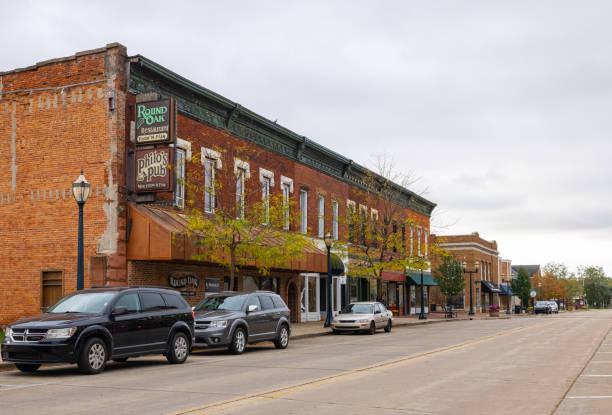

In [ ]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/segmentation_input.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

### Image Classification

In [ ]:
image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small-imagenet1k-1-layer")
model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-small-imagenet1k-1-layer")

inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

cinema, movie theater, movie theatre, movie house, picture palace


## Citation

Oquab, M., Darcet, T., Moutakanni, T., Vo, H., Szafraniec, M., Khalidov, V., Fernandez, P., Haziza, D., Massa, F., El-Nouby, A., Assran, M., Ballas, N., Galuba, W., Howes, R., Huang, P.-Y., Li, S.-W., Misra, I., Rabbat, M., Sharma, V., … Bojanowski, P. (2024). DINOv2: Learning Robust Visual Features without Supervision (arXiv:2304.07193). arXiv. http://arxiv.org/abs/2304.07193
